In [1]:
# Import general util libraries

import torch
from torch.utils import data
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn') 
matplotlib.rcParams['font.family'] = 'serif'  
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Avoid iOS bug with pyplot. 


# Data loading
from utils.dlc_practical_prologue import generate_pair_sets



# Import models
from models.LeNet import lenet
from models.LinearReluNet import linear_relu_net
from models.SimpleConvNet import simple_conv_net
from models.ResNet import residual_net
from models.LeNet_2 import lenet_2
from models.Conv_Net_2 import conv_net_2
from models.Siamese import siamese

# Import plot utils
from utils.plot_utils import *
from utils.ml_utils import *
from utils.data_utils import *
from utils.metrics import *



In [2]:
N = 1000  # Number of pairs
NN_ARGS = {"input_size": 14 * 14, "num_classes": 10}
DROP = {"d1" : 0, "d2" : 0}
DROP_AUX = {"d1" : 0, "d2" : 0}
DROP_RES = {"d" : 0.15}
DROP_RES_2 = {"d" : 0.15, "input_channels" : 2}
BATCH_SIZE = 10
NUM_EPOCHS = 25
NUM_ITER = 1
MODELS = {
    "SimpleConvNet" : {"args" : DROP, "f" :simple_conv_net, "f2" :conv_net_2, "flatten": False, "name":"Simple Conv" },
    "LinearRelu": {"args": NN_ARGS, "f": linear_relu_net, "flatten": True, "name":"Linear ReLu"},
    "LeNet": {"args": DROP, "f": lenet,"f2":lenet_2, "flatten": False, "name":"LeNet"},
    "ResNet": {"args": DROP_RES, "f": residual_net, "args2": DROP_RES_2,"flatten": False, "name":"Residual Net"},
    "Siamese" : {"f" : siamese}
}

In [3]:
def full_train_test(model_info, num_iter, num_epochs, data_size, batch_size, nb_channels = 2,split= True, weight_sharing = True, auxiliary = False, r = 1, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Copy all model parameters to the GPU
    
    

    
    if (nb_channels == 2) & (model_info.get("name") == "Residual Net") & (not split):
        args = model_info.get('args2')
    else:
        args = model_info.get("args")
    
    if args is None:
        if (nb_channels == 2) & (model_info.get("name") != "Residual Net") & (not split):
            model = model_info.get('f2')()
        else: 
            model = model_info.get('f')()
            
        if weight_sharing != True :
            model_1 = model_info.get('f')()
    else:
        if (nb_channels == 2) & (model_info.get("name") != "Residual Net") & (not split):
            model = model_info.get('f2')(**args)
        else:
            model = model_info.get('f')(**args)
   
    if (split):
        model1 = model
        args = {"m1": model1, "ws": weight_sharing}
        model = siamese(**args)
    
    model = model.to(device)
    
    all_train_losses = [] 
    all_test_losses = []
    
    all_test_accuracies = []
    
    for it in range(1, num_iter + 1):
        print("Iteration %d" % it)
        
        # Generate a new dataset
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(data_size)
        
        if nb_channels==1: 
            
        # Build Keras loaders for train and test datasets batches.
            tr_loader, te_loader = build_train_loaders(train_input, train_classes, test_input, test_classes, batch_size)
            tr_losses, te_losses = train_model(model, device, num_epochs, tr_loader, te_loader, model_info.get('flatten'), verbose)
        else:
            tr_loader, te_loader = build_two_ch_loader(train_input,train_classes, train_target, test_input, test_classes,test_target,  batch_size)
            tr_losses, te_losses = train_model_two_ch(model, device, num_epochs, tr_loader, te_loader, split,weight_sharing,auxiliary, r, model_info.get('flatten'), verbose)
        

       # plot_train_test(tr_losses, te_losses, model_info.get('name'))
    
        if verbose:
            print("Final train loss: %.4f" % tr_losses[-1])
            print("Final test loss: %.4f" % te_losses[-1])
        
        all_train_losses.append(tr_losses)
        all_test_losses.append(te_losses)
        
        _,_,_, acc_input, acc_target, _ = generate_pair_sets(data_size)
        acc_loader = build_test_loader(acc_input, acc_target, batch_size)
        
        if nb_channels == 1:
            acc = accuracy(model, acc_loader, False , model_info.get('flatten') )
        else: 
            acc = accuracy_two_ch(model, acc_loader,split , model_info.get('flatten') )
                
        if verbose:
            print("Test accuracy: %.4f" % acc)
        all_test_accuracies.append(acc)
    
    #if weight_sharing == True:
    plot_losses(all_train_losses, all_test_losses, model_info.get('name'))
    
    plot_accuracy(all_test_accuracies, model_info.get('name'))
    
    return model
       
            


Iteration 1


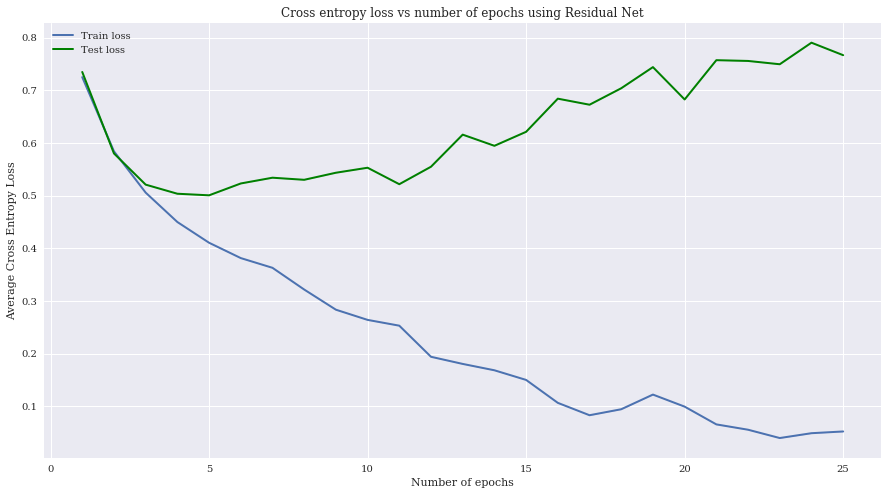

Test accuracy mean = 0.795


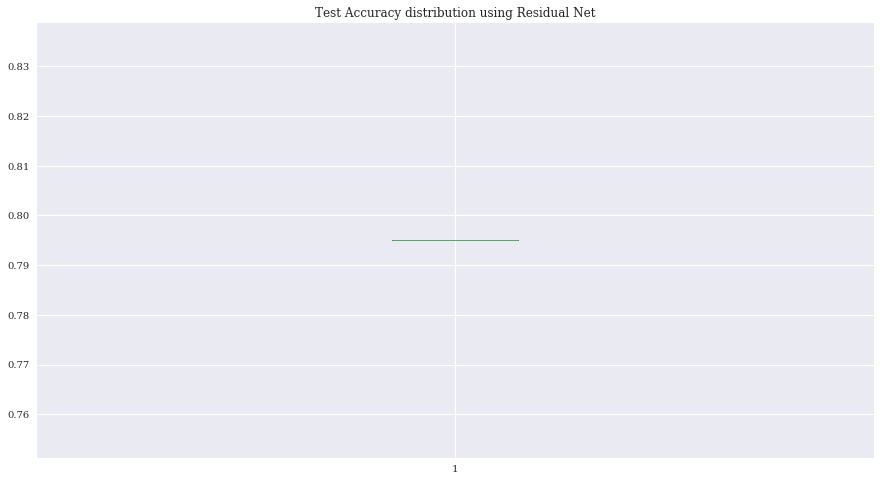

In [5]:
model = full_train_test(MODELS.get('ResNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,False, False, False, 0.2)

In [5]:
all_tests = []
for i in range(10):
    _,_,_, acc_input, acc_target, _ = generate_pair_sets(1000)
    acc_loader = build_test_loader(acc_input, acc_target, 10)
    acc = accuracy_two_ch(model, acc_loader,True , False)
    all_tests.append(acc)

Test accuracy mean = 0.779


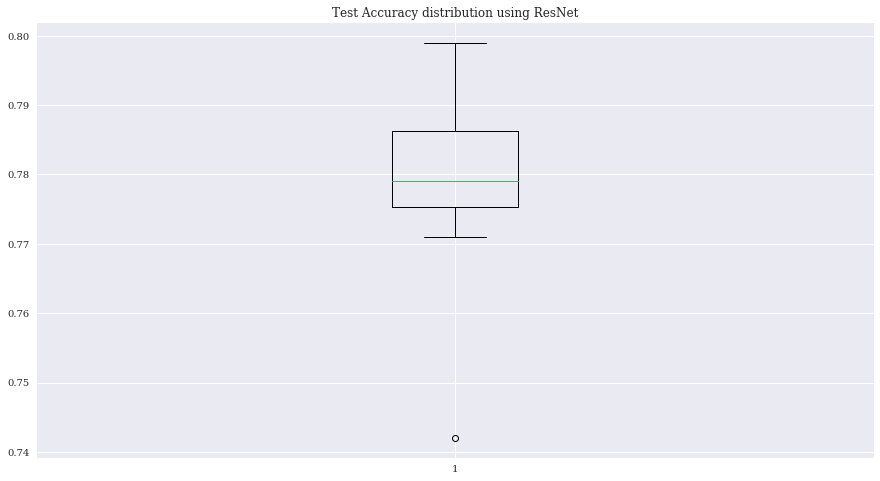

In [6]:
plot_accuracy(all_tests, 'ResNet')

Iteration 1


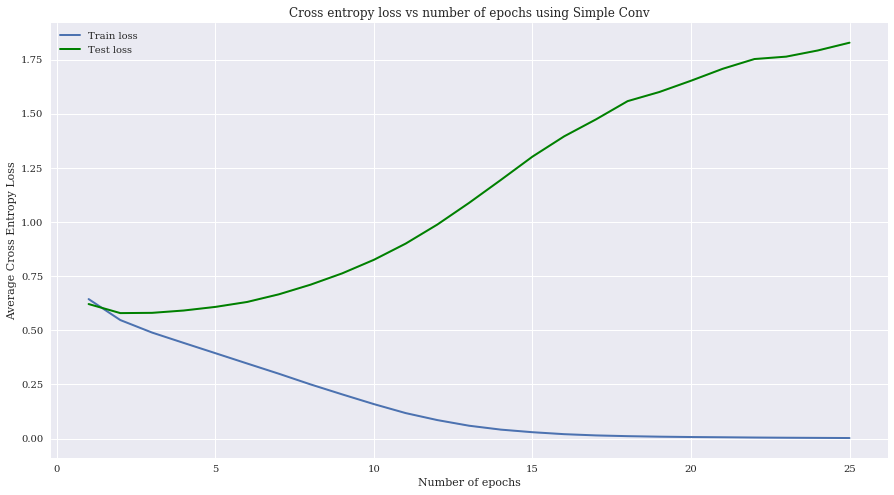

Test accuracy mean = 0.684


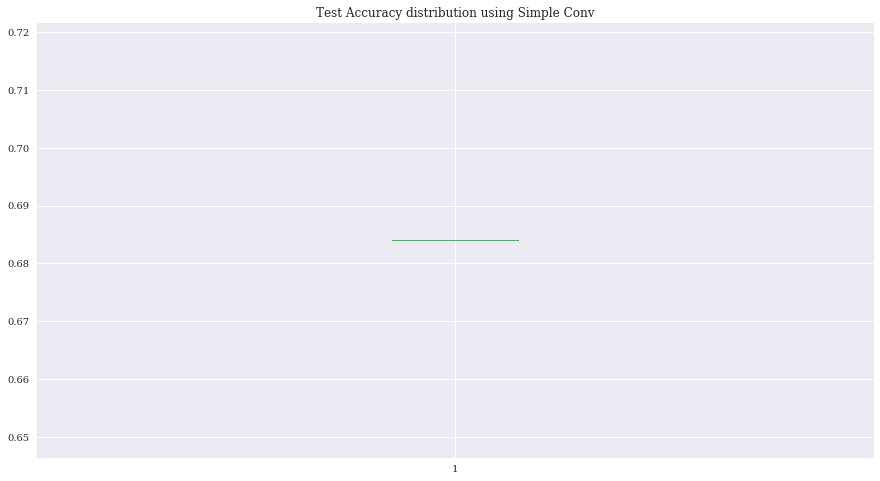

In [13]:
full_train_test(MODELS.get("SimpleConvNet"), 1, NUM_EPOCHS, N, BATCH_SIZE, nb_channels = 2, True,,verbose = False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


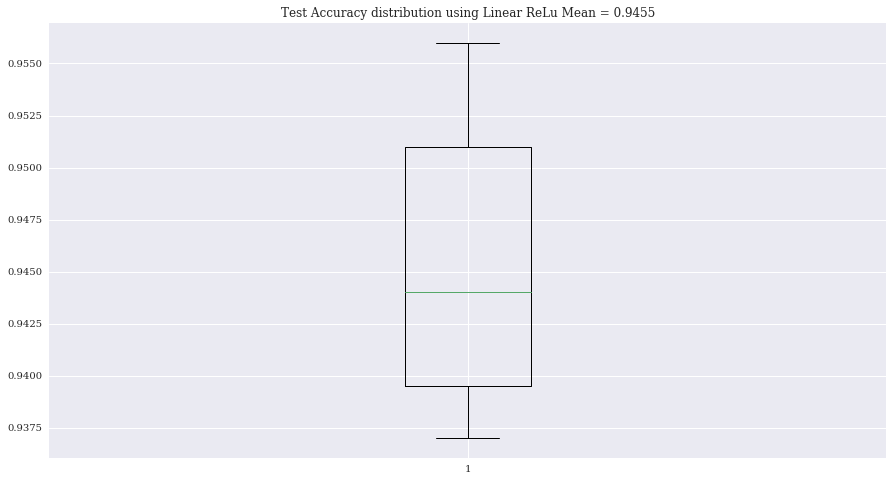

In [7]:
full_train_test(MODELS.get("LinearRelu"), NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = False,verbose = False)

Iteration 1


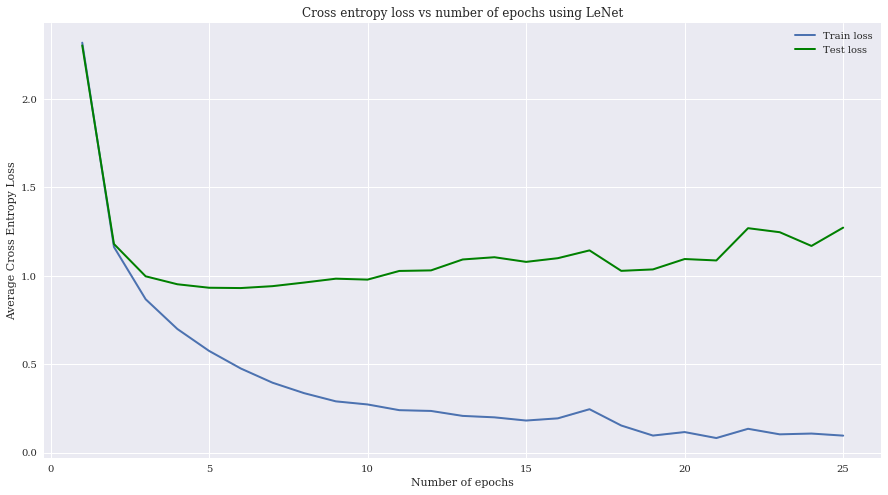

Test accuracy mean = 0.892


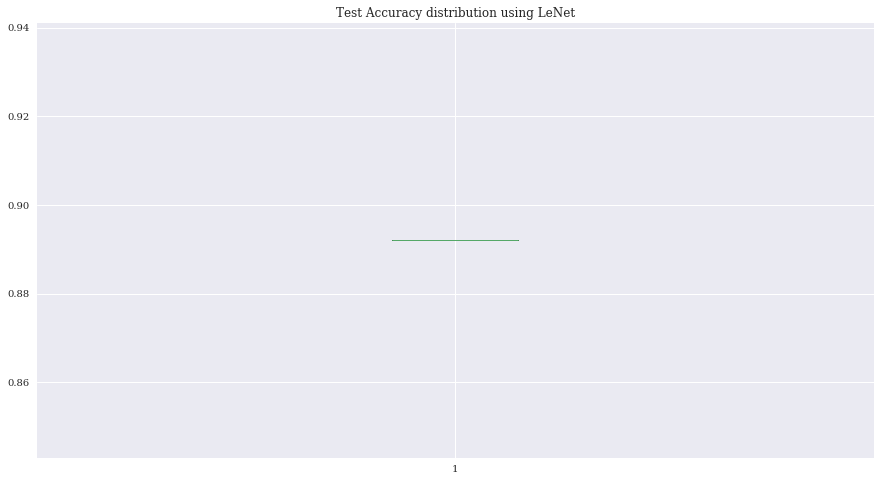

In [23]:
model = full_train_test(MODELS.get("LeNet"), NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = True,verbose = False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


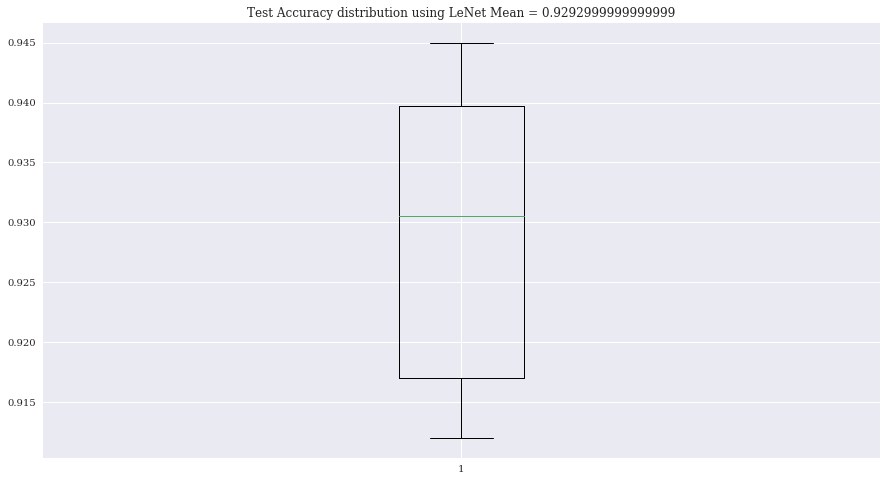

In [9]:
full_train_test(MODELS.get("LeNet"), NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = False,verbose = False)

Iteration 1


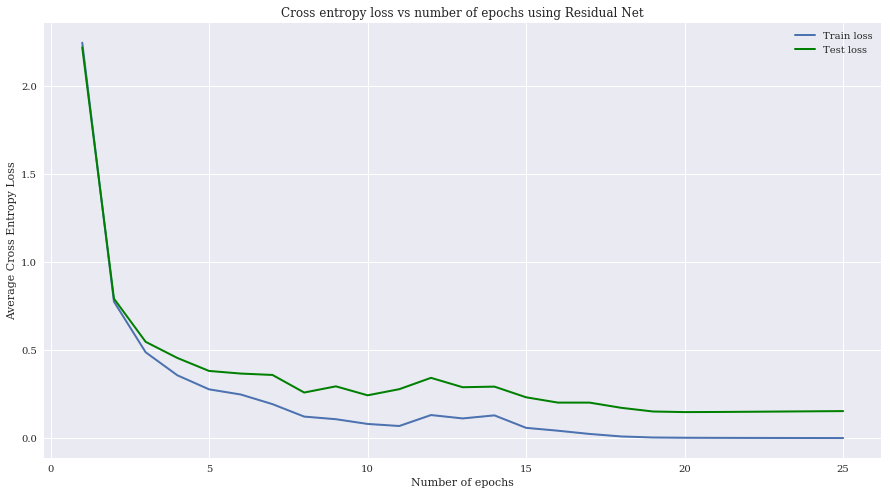

Test accuracy mean = 0.982


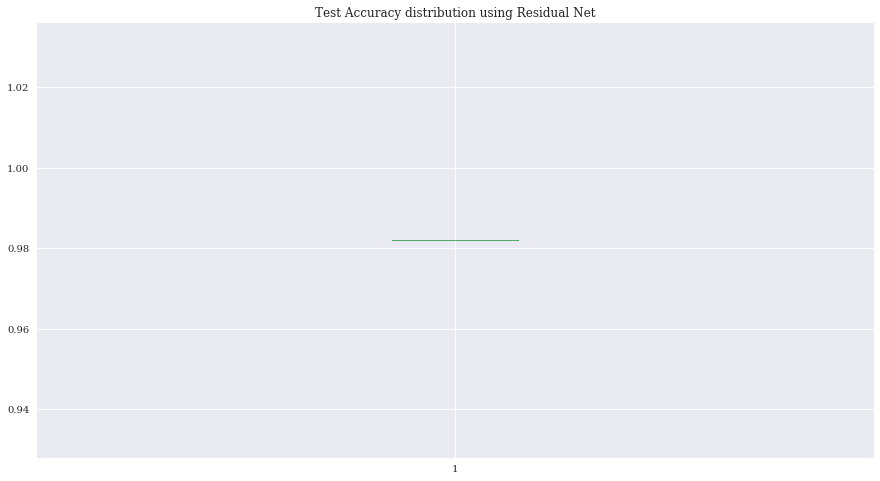

In [6]:
full_train_test(MODELS.get("ResNet"), 1, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = True,verbose = False)

Iteration 1
Test accuracy mean = 0.977


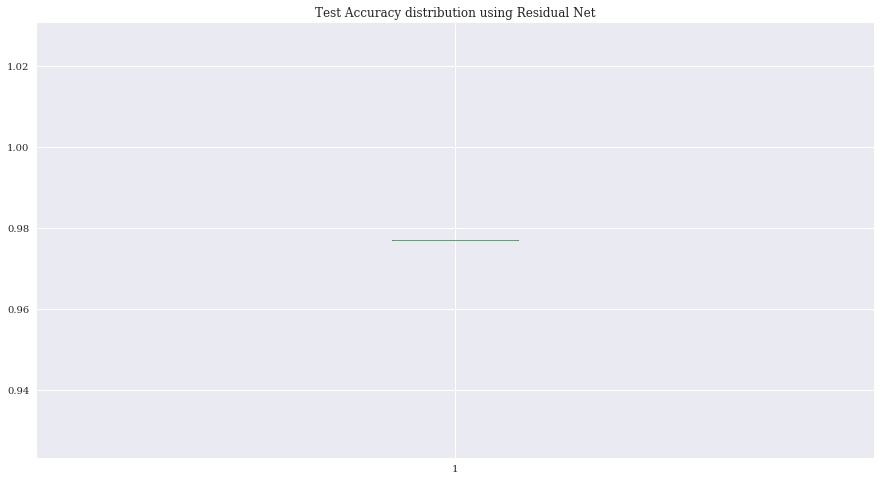

In [7]:
full_train_test(MODELS.get("ResNet"), 1, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = False,verbose = False)